# Traffic Prediction using Spatio-Temporal GNNs

![Traffic](./PredictingTraffic.png)

In this project, we implement a spatio-temporal Graph Convolutional Network (GCN) to predict short-term traffic at each sensor node in a 10×10 grid network.

### Project Goals

By the end of this implementation, you will:

1. **Simulate & normalize** multivariate time-series data on a graph  
2. **Create sliding-window data loaders** for sequence-to-one prediction  
3. **Define and implement** a temporal + spatial GCN architecture in PyTorch  
4. **Train** the model with proper regularization and learning-rate scheduling  
5. **Evaluate** model performance (MSE) and **visualize** true vs. predicted traffic

### Technical Stack

This project uses only the following libraries:
```python
import numpy as np, networkx as nx, matplotlib.pyplot as plt, torch
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
```

In [1]:
# Make Imports here:
import numpy as np, networkx as nx, matplotlib.pyplot as plt, torch
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim

### Dataset Overview

For this project, we've prepared a synthetic traffic network and preprocessed the data for you.

**The dataset is ready to use** — you don't need to generate or normalize the raw traffic data.  

The following variables are already available in your notebook:

```python
# 1) Graph structure (normalized adjacency)
A_norm    # torch.Tensor of shape [100×100]

# 2) Simulated, z-scored traffic signals
signals   # NumPy array of shape [500, 100]
          #  → each row = one time step across 100 sensor nodes

# 3) Sliding Window Tensors
X         # NumPy array, shape [476 × 24 × 100]
Y         # NumPy array, shape [476 × 100]
```

**How to use the data:**

```python
import torch
X_tensor = torch.tensor(X, dtype=torch.float32)  # [476,24,100]
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # [476,100]
```

Simply wrap these in `TensorDataset` / `DataLoader`, then define, train, and evaluate your GCN. Focus your effort on the data loader, model architecture, training loop, and evaluation.

Take some time to understand the data preparation code in the next cell.

In [2]:
# Do not change this part of the code:
np.random.seed(0); torch.manual_seed(0)

gsize, N = 10, 100
G = nx.convert_node_labels_to_integers(nx.grid_2d_graph(gsize, gsize))
A  = nx.to_numpy_array(G);  A_hat = A + np.eye(N)
D_hat = np.diag(A_hat.sum(1));  A_norm = torch.tensor(
    np.linalg.inv(np.sqrt(D_hat)) @ A_hat @ np.linalg.inv(np.sqrt(D_hat)),
    dtype=torch.float32)

# 3. Simulate traffic (clean sinusoid + 𝒩(0, 0.05²) noise) and z-score
T, t = 500, np.arange(500)
raw = np.stack([
    np.sin(np.random.uniform(.15,.3)*t + 2*np.pi*np.random.rand()) +
    0.05*np.random.randn(T) for _ in range(N)], axis=1)          # [T,N]
W = 24;  train_cut = 400 + W
μ, σ = raw[:train_cut].mean(0, keepdims=True), raw[:train_cut].std(0, keepdims=True)
signals = (raw - μ)/σ

X, Y = [], []
for i in range(T-W): X.append(signals[i:i+W]), Y.append(signals[i+W])
X, Y = np.stack(X), np.stack(Y)                                  # [476,24,100], [476,100]

Xtr = torch.tensor(X[:400], dtype=torch.float32)
Ytr = torch.tensor(Y[:400], dtype=torch.float32)
Xte = torch.tensor(X[400:], dtype=torch.float32)
Yte = torch.tensor(Y[400:], dtype=torch.float32)

# Implementation: Spatio-Temporal GCN for Traffic Prediction

In this section, we build a **Spatio-Temporal Graph Convolutional Network (ST-GCN)** to predict traffic across nodes in a 10×10 grid.

**Recommended Reading:** [Spatial-Temporal GCNs Explained](https://thachngoctran.medium.com/spatial-temporal-graph-convolutional-networks-st-gcn-explained-bf926c811330)

---

## Implementation Steps

### 1. Define the ST-GCN Model
Implement a spatio-temporal GCN based on:
- **Temporal feature extraction** (using Conv1D over the time dimension)
- **Graph convolution** using the normalized adjacency `A_norm`
- **Nonlinear activations** (e.g., ReLU)
- **Dropout** and **BatchNorm** for regularization

### 2. Training Configuration
- **Loss function**: Mean Squared Error (MSELoss)
- **Optimizer**: Adam with learning rate 0.003
- **Scheduler**: CyclicLR with:
  - `base_lr=1e-3`
  - `max_lr=3e-3`
  - `step_size_up=60`
  - `cycle_momentum=False`

### 3. Training Process
- Train for **at least 300 epochs**
- Record and print the **Training MSE Loss** every 30 epochs
- Monitor convergence and adjust if needed

### 4. Model Evaluation
- Compute and print the **Test MSE Loss** after training
- Set model to `.eval()` mode during evaluation
- Do **not** shuffle the test set

### 5. Visualization & Analysis
- Extract true and predicted traffic values for **Node 50** from the test set
- **Rescale** predictions and true values back to original traffic units using `μ` and `σ`
- Plot both curves (`True` vs `Predicted`) with proper labels, title, and legend
- Analyze how well the model predictions match the true signal

---

## Expected Outcomes

- A working ST-GCN implementation capturing both spatial and temporal patterns
- Decreasing training MSE showing successful learning
- Test MSE demonstrating generalization capability
- Visualization showing accurate traffic predictions on held-out data
- Analysis of model strengths and limitations

Epoch 030 | Train MSE: 0.6522
Epoch 060 | Train MSE: 0.6240
Epoch 090 | Train MSE: 0.6119
Epoch 120 | Train MSE: 0.5949
Epoch 150 | Train MSE: 0.5857
Epoch 180 | Train MSE: 0.5813
Epoch 210 | Train MSE: 0.5788
Epoch 240 | Train MSE: 0.5634
Epoch 270 | Train MSE: 0.5479
Epoch 300 | Train MSE: 0.5499
Test MSE Loss: 1.1226


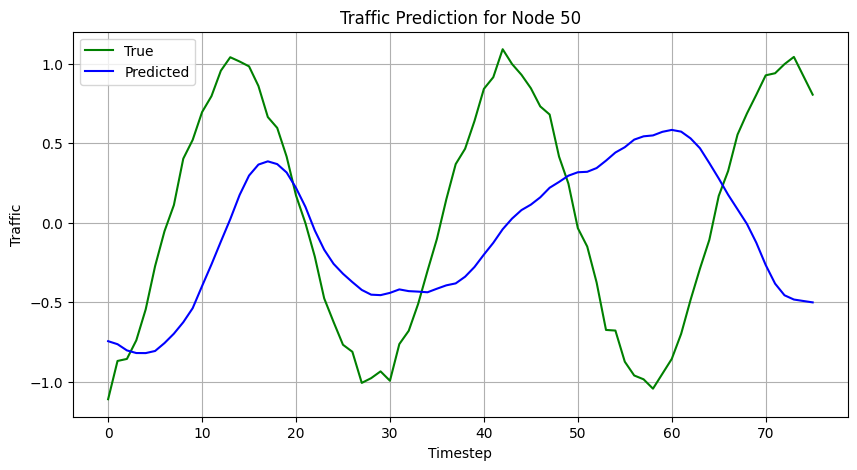

In [10]:
# Spatio-Temporal net (Conv->BN->ReLU->GCN->ReLU->GCN)
class STGCN(nn.Module):
    def __init__(self, in_nodes=100, gcn_hidden=64, conv_hidden=32, dropout=0.5):
        super().__init__()
        
        self.gc1 = nn.Sequential(
            nn.Linear(in_nodes, gcn_hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.gc2 = nn.Sequential(
            nn.Linear(gcn_hidden, gcn_hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.temporal = nn.Sequential(
            nn.Conv1d(in_channels=gcn_hidden, out_channels=conv_hidden, kernel_size=3, padding=1),
            nn.BatchNorm1d(conv_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(in_channels=conv_hidden, out_channels=in_nodes, kernel_size=3, padding=1)
        )

        self.output = nn.Linear(in_nodes, in_nodes)

    def forward(self, x, A_norm):
        B, T, N = x.shape
        A = A_norm.to(x.device)
        x = torch.einsum('ij,btj->bti', A, x)
        x = self.gc1(x)
        x = self.gc2(x)
        x = x.permute(0, 2, 1)
        x = self.temporal(x)
        x = x.mean(dim=2)

        return self.output(x)



# Define Hyperparameters
model = STGCN().to('cuda')
opt = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
sched = optim.lr_scheduler.CyclicLR(
    opt, base_lr=1e-3, max_lr=3e-3, step_size_up=60, cycle_momentum=False
)
loss_fn = nn.MSELoss()

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xtr, Ytr), batch_size=32, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Xte, Yte), batch_size=32, shuffle=False
)


# Training
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to('cuda'), yb.to('cuda')
        pred = model(xb, A_norm.to('cuda'))
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        sched.step()
        opt.zero_grad()
        total_loss += loss.item() * xb.size(0)

    if epoch % 30 == 0:
        print(f"Epoch {epoch:03d} | Train MSE: {total_loss / len(train_loader.dataset):.4f}")


# Evaluation
model.eval()
test_loss = 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to('cuda'), yb.to('cuda')
        pred = model(xb, A_norm.to('cuda'))
        loss = loss_fn(pred, yb)
        test_loss += loss.item() * xb.size(0)

print(f"Test MSE Loss: {test_loss / len(test_loader.dataset):.4f}")


# Plot Node 50 (rescaled)
node_id = 50
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to('cuda')
        pred = model(xb, A_norm.to('cuda')).cpu().numpy()
        all_preds.append(pred[:, node_id])
        all_true.append(yb[:, node_id].numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)
true_rescaled = all_true * σ[0, node_id] + μ[0, node_id]
pred_rescaled = all_preds * σ[0, node_id] + μ[0, node_id]

plt.figure(figsize=(10, 5))
plt.plot(true_rescaled, label='True', color='green')
plt.plot(pred_rescaled, label='Predicted', color='blue')
plt.title("Traffic Prediction for Node 50")
plt.xlabel("Timestep")
plt.ylabel("Traffic")
plt.legend()
plt.grid(True)
plt.show()
